In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import  MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
%matplotlib inline

from tensorflow.keras.utils import plot_model

#tensorboard: currently some error
#!pip install -U tensorboardcolab
#from tensorboardcolab import *

# json and pretty print
import json
import pprint
# to persist the numpy arrays data
import h5py
# handle logging
tf.logging.set_verbosity(tf.logging.INFO)

print(tf.__version__)
df_ibuprofen = pd.read_csv('data/paracetamol.csv')
print(df_ibuprofen.dtypes.value_counts())
print(df_ibuprofen.columns.tolist())
print('length of columns :', len(df_ibuprofen.columns.tolist()))
print(df_ibuprofen.count())
df_ibuprofen.head()

1.12.0
float64    2
int64      1
object     1
dtype: int64
['quantity', 'kgPrice', 'dateUnix', 'dateIso']
length of columns : 4
quantity    2311
kgPrice     2311
dateUnix    2311
dateIso     2311
dtype: int64


,quantity,kgPrice,dateUnix,dateIso
0,1.0,0.750000,1483311600,01/01/2017
1,5986.0,3.039779,1483311600,01/01/2017
2,14137.2,3.356817,1483311600,01/01/2017
3,2500.0,6.887044,1483311600,01/01/2017
4,17789.2,3.401647,1483311600,01/01/2017


# Functions

In [2]:
# Calculating Mean Absolute Percentage Error of predictions
def calc_mape(predicted_data, true_data):\
    return np.divide(np.sum(np.divide(np.absolute(predicted_data - true_data), true_data), 0), true_data.shape[0])
  
def plot_prediction(original, predicted):
    #fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    # Get subplots
    f, (plt1, plt2, plt3) = plt.subplots(3)
    # Get Daily errors
    
    a = original
    b = predicted
    if(len(original.shape) > 1):
        a = original.reshape(original.shape[0]*original.shape[1])
    if(len(predicted.shape) > 1):
        b = predicted.reshape(predicted.shape[0]*predicted.shape[1])
    
    daily_errors = abs(a - b)
    t = 7
    weekly_errors = temp = [np.float(np.sum(daily_errors[i:i+t])/t) for i in range(0, len(daily_errors), t)]
  
    # Calculate R2 metric
  
    # FROM wikipedia: 
    # Values of R2 outside the range 0 to 1 can occur when the model fits the data worse than a horizontal hyperplane. 
    # This would occur when the wrong model was chosen.
    m = np.mean(a)
    ss_tot = np.sum(np.power((a - m), 2))
    ss_res = np.sum(np.power((a - b), 2))
    r_square = 1 - (ss_res / ss_tot)
    r_square = "{0:.4f}".format(r_square)
    mape = calc_mape(b, a)
  
    # Get weekly errors
    # plot original vs predicted  
    plt1.plot(original, color='black', label = 'Original data') 
    plt1.plot(predicted, color='blue', label = 'Predicted data')

    # PLOT DAILY ERRORS
    plt2.plot(daily_errors, color='red')
    
    # PLOT WEEKLY ERRORS
    for i, e in enumerate(weekly_errors):
        plt3.bar(x=i*7, height=e, width=5, color='red')

    plt1.set_title('Actual and Predicted - R2: '+str(r_square) + ' - MAPE:'+str(mape))  
    plt2.set_title('Daily Errors')
    plt3.set_title('Weekly Errors')
  
    # IF YOU ARE USING COLAB, USE THIS:
    plt.subplots_adjust(left=1, bottom=1, right=4, top=3, wspace=None, hspace=1)
  
    # IF YOU ARE USING YOUR LOCAL AND SHOWING THE RESULTS USE THE FOLLOWING:
    # plt.subplots_adjust(left=0.05, bottom=0.05, right=0.90, top=0.90, wspace=None, hspace=0.4)
    
    plt.show()

# returns normalized dataset between a and b
def minmax_norm(dataset, a, b):
    # NORMALIZE DATASET
    d = dataset
    mi = np.min(dataset)
    ma = np.max(dataset)

    norm_dataset = ((b-a) * ((d - mi)/(ma - mi))) + a
    return norm_dataset

def minmax_denorm(old_data, val, a=-1, b=1):
    mi = min(old_data)
    ma = max(old_data)

    return ((val - a) * (ma-mi) / (b-a)) + mi

def get_test(X, percentage=0.9):
    iXPercentage = int(len(X) * percentage) 
    X_train_val = X[0:iXPercentage]
    X_test = X[iXPercentage:]
    return X_train_val, X_test
  
def get_data_dict(d_list, windows):
    length = len(d_list[0])
    step = 1
    forecast = 1

    _dict = {}
    for window in windows:
        X = []
        Y = []
        for i in range(0, length, step):
            try:
                # Get windowed data
                windowed_features_list = []
                for j in range(len(d_list)):
                    windowed_features_list.append(d_list[j][i:i+window])

                # ALWAYS TAKE THE FIRST data 
                y_i = d_list[0][i + window + forecast - 1] # indexing is important.
                x_i = np.column_stack(tuple(windowed_features_list))
            except Exception as e:
                print(e)
                break
            
            X.append(x_i)
            Y.append(y_i)
            #print(X)
        _dict[window] = {'X': np.array(X), 'Y': np.array(Y)}
    
    return _dict

In [3]:
dataset = df_ibuprofen.copy()
dataset = dataset.drop("dateIso", axis=1)
dataset.head()

,quantity,kgPrice,dateUnix
0,1.0,0.750000,1483311600
1,5986.0,3.039779,1483311600
2,14137.2,3.356817,1483311600
3,2500.0,6.887044,1483311600
4,17789.2,3.401647,1483311600


In [4]:
def fn(group):
    group['weighted_avg_kgprice'] = group['kgPrice'] * group['quantity'] / group['quantity'].sum()
    return group

d_agg = {'weighted_avg_kgprice':'sum', 
         'quantity':'sum'
        }

dataset_weighted = dataset.groupby('dateUnix', sort=False).apply(fn).groupby('dateUnix').agg(d_agg)
dataset_weighted.head(15)
#dataset_weighted

#print(dataset.groupby('dateUnix', sort=False).apply(fn))

,weighted_avg_kgprice,quantity
dateUnix,,
1483311600,3.448643,142727.8
1483398000,4.185645,34300.0
1483484400,4.050100,16000.0
1483570800,3.488540,92137.2
1483657200,3.203516,91000.0
1483743600,3.462037,68500.0
1483830000,4.802115,14000.0
1483916400,3.656298,55500.0
1484089200,4.226170,22500.0


In [5]:
column_names = ['weighted_avg_kgprice', 'quantity']

In [6]:
prices = np.array(dataset_weighted[column_names[0]])
volumes = np.array(dataset_weighted[column_names[1]])
#print(prices)
#print(volumes)

In [7]:
non_normalized_data = get_data_dict(d_list=[volumes, prices], windows=[6, 8, 12])

x = non_normalized_data[6]['X']
y = non_normalized_data[6]['Y']
print(x[0])
print(y[0])
print('*'*100)
print(x[1])
print(y[1])
print('*'*100)

index 607 is out of bounds for axis 0 with size 607
index 607 is out of bounds for axis 0 with size 607
index 607 is out of bounds for axis 0 with size 607
[[1.42727800e+05 3.44864252e+00]
 [3.43000000e+04 4.18564490e+00]
 [1.60000000e+04 4.05010000e+00]
 [9.21372000e+04 3.48854046e+00]
 [9.10000000e+04 3.20351626e+00]
 [6.85000000e+04 3.46203679e+00]]
14000.0
****************************************************************************************************
[[3.43000000e+04 4.18564490e+00]
 [1.60000000e+04 4.05010000e+00]
 [9.21372000e+04 3.48854046e+00]
 [9.10000000e+04 3.20351626e+00]
 [6.85000000e+04 3.46203679e+00]
 [1.40000000e+04 4.80211500e+00]]
55500.0
****************************************************************************************************


In [8]:
# Extract Test
daily_prices, test_daily_prices = get_test(prices)
daily_volumes, test_daily_volumes = get_test(volumes)
#print(len(daily_prices))
print(daily_prices.shape)

(546,)


In [9]:
data_dict = get_data_dict(d_list=[daily_volumes, daily_prices], 
                                windows=[6,8,12])
x = data_dict[6]['X']
y = data_dict[6]['Y']
print(x[0])
print(y[0])
print('*'*100)
print(x[1])
print(y[1])
print('*'*100)

index 546 is out of bounds for axis 0 with size 546
index 546 is out of bounds for axis 0 with size 546
index 546 is out of bounds for axis 0 with size 546
[[1.42727800e+05 3.44864252e+00]
 [3.43000000e+04 4.18564490e+00]
 [1.60000000e+04 4.05010000e+00]
 [9.21372000e+04 3.48854046e+00]
 [9.10000000e+04 3.20351626e+00]
 [6.85000000e+04 3.46203679e+00]]
14000.0
****************************************************************************************************
[[3.43000000e+04 4.18564490e+00]
 [1.60000000e+04 4.05010000e+00]
 [9.21372000e+04 3.48854046e+00]
 [9.10000000e+04 3.20351626e+00]
 [6.85000000e+04 3.46203679e+00]
 [1.40000000e+04 4.80211500e+00]]
55500.0
****************************************************************************************************


In [10]:
norm_daily_prices  = minmax_norm(daily_prices, a=-1, b=1)
norm_daily_volumes = minmax_norm(daily_volumes, a=-1, b=1)

normalized_data = get_data_dict(d_list=[norm_daily_volumes, norm_daily_prices], windows=[6,8,12])

index 546 is out of bounds for axis 0 with size 546
index 546 is out of bounds for axis 0 with size 546
index 546 is out of bounds for axis 0 with size 546


In [11]:
x = normalized_data[6]['X']
y = normalized_data[6]['Y']
print(x[0])
print(y[0])
print('*'*100)
print(x[1])
print(y[1])
print('*'*100)

[[ 0.43837965 -0.91967656]
 [-0.65435887 -0.88931587]
 [-0.83878681 -0.89489962]
 [-0.07147389 -0.91803297]
 [-0.08293462 -0.92977449]
 [-0.30969028 -0.91912478]]
-0.8589428651332945
****************************************************************************************************
[[-0.65435887 -0.88931587]
 [-0.83878681 -0.89489962]
 [-0.07147389 -0.91803297]
 [-0.08293462 -0.92977449]
 [-0.30969028 -0.91912478]
 [-0.85894287 -0.86392048]]
-0.4407046557975123
****************************************************************************************************


# BI-DIR LSTM

In [12]:
w = 6
#w = 8
#w = 12
batch_size = 32

In [13]:
def build_model(tensor_shape):
    #create model
    model = keras.Sequential()
    units = tensor_shape[0]
    #model.add(layers.Bidirectional(LSTM(units, return_sequences=True, activation='relu'), input_shape=(tensor_shape[0], tensor_shape[1])))
    model.add(layers.Bidirectional(LSTM(units, return_sequences=True, activation='relu'), batch_input_shape=(None, tensor_shape[0], tensor_shape[1])))
    
    
    #model.add(layers.Bidirectional(layers.LSTM(5, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]))))
    #model.add(layers.LSTM(4, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
    #model.add(layers.LSTM(4, activation='relu'))
    model.add(Flatten())
    model.add(layers.Dense(1))
    #optimizer = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
    return model

In [14]:
model = build_model(tensor_shape=(w, 2))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 6, 12)             432       
_________________________________________________________________
flatten (Flatten)            (None, 72)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 73        
Total params: 505
Trainable params: 505
Non-trainable params: 0
_________________________________________________________________


In [15]:
learning_rate=0.0001
epochs=1000
verbose=1
model_dir = 'models/'
model_save_name = model_dir + 'bidirlstm_multivariate_model_paracetamol_quantity_norm.h5'
    
#opt_1 = tf.keras.optimizers.Adam(learning_rate)
opt_1 = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
loss_func = tf.keras.losses.mean_squared_error

metrics = []
metrics.append(tf.keras.metrics.mean_absolute_error)
metrics.append(tf.keras.metrics.mean_squared_error)
metrics.append(tf.keras.metrics.mean_absolute_percentage_error)

print("Model will be saved at: " + model_save_name)
model.compile(optimizer=opt_1, 
                  loss=loss_func, 
                  metrics=metrics)
    
callbacks = []
cp = tf.keras.callbacks.ModelCheckpoint(filepath=model_save_name, verbose=1, save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
    
callbacks.append(cp)
callbacks.append(early_stop)    

Model will be saved at: models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5


In [16]:
def get_train_validation(X, y, percentage=0.8):
    iXPercentage = int(len(X) * percentage) 
    iYPercentage = int(len(y) * percentage)
    X_train = X[0:iXPercentage]
    Y_train = y[0:iYPercentage]
    
    #X_train, Y_train = shuffle_in_unison(X_train, Y_train)

    X_val = X[iXPercentage:]
    Y_val = y[iYPercentage:]
    return X_train, X_val, Y_train, Y_val

In [17]:
nX = normalized_data[w]['X']
nY = normalized_data[w]['Y']
X_train, X_val, Y_train, Y_val = get_train_validation(nX, nY)

In [18]:
print('X_train: '+str(X_train.shape))
print('X_val: '+str(X_val.shape))

X_train: (432, 6, 2)
X_val: (108, 6, 2)


In [19]:
print(X_train[0])
print(Y_train[0])
print('*'*50)
print(X_train[1])
print(Y_train[1])
print('*'*50)

[[ 0.43837965 -0.91967656]
 [-0.65435887 -0.88931587]
 [-0.83878681 -0.89489962]
 [-0.07147389 -0.91803297]
 [-0.08293462 -0.92977449]
 [-0.30969028 -0.91912478]]
-0.8589428651332945
**************************************************
[[-0.65435887 -0.88931587]
 [-0.83878681 -0.89489962]
 [-0.07147389 -0.91803297]
 [-0.08293462 -0.92977449]
 [-0.30969028 -0.91912478]
 [-0.85894287 -0.86392048]]
-0.4407046557975123
**************************************************


In [20]:
history = model.fit(X_train, Y_train, 
                    epochs = epochs,  batch_size = batch_size, 
                    verbose=verbose, validation_data=(X_val, Y_val), validation_split=0.8, callbacks=callbacks)

Train on 432 samples, validate on 108 samples
Epoch 1/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.6908 - mean_absolute_error: 0.7719 - mean_squared_error: 0.6908 - mean_absolute_percentage_error: 174.8518
Epoch 00001: val_loss improved from inf to 0.61818, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [==============================] - 4s 9ms/step - loss: 0.6911 - mean_absolute_error: 0.7724 - mean_squared_error: 0.6911 - mean_absolute_percentage_error: 172.9195 - val_loss: 0.6182 - val_mean_absolute_error: 0.7255 - val_mean_squared_error: 0.6182 - val_mean_absolute_percentage_error: 141.9526
Epoch 2/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.6555 - mean_absolute_error: 0.7526 - mean_squared_error: 0.6555 - mean_absolute_percentage_error: 163.6796
Epoch 00002: val_loss improved from 0.61818 to 0.58825, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [========

416/432 [===========================>..] - ETA: 0s - loss: 0.3444 - mean_absolute_error: 0.5312 - mean_squared_error: 0.3444 - mean_absolute_percentage_error: 137.1865
Epoch 00014: val_loss improved from 0.33831 to 0.32110, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [==============================] - 0s 1ms/step - loss: 0.3468 - mean_absolute_error: 0.5325 - mean_squared_error: 0.3468 - mean_absolute_percentage_error: 135.2898 - val_loss: 0.3211 - val_mean_absolute_error: 0.4927 - val_mean_squared_error: 0.3211 - val_mean_absolute_percentage_error: 86.7779
Epoch 15/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.3284 - mean_absolute_error: 0.5167 - mean_squared_error: 0.3284 - mean_absolute_percentage_error: 142.0708
Epoch 00015: val_loss improved from 0.32110 to 0.30446, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [==============================] - 1s 1ms/step - loss: 0.3280 - 

416/432 [===========================>..] - ETA: 0s - loss: 0.1682 - mean_absolute_error: 0.3556 - mean_squared_error: 0.1682 - mean_absolute_percentage_error: 219.0534
Epoch 00027: val_loss improved from 0.17377 to 0.16683, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [==============================] - 1s 1ms/step - loss: 0.1674 - mean_absolute_error: 0.3540 - mean_squared_error: 0.1674 - mean_absolute_percentage_error: 213.5201 - val_loss: 0.1668 - val_mean_absolute_error: 0.3394 - val_mean_squared_error: 0.1668 - val_mean_absolute_percentage_error: 95.9152
Epoch 28/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1608 - mean_absolute_error: 0.3449 - mean_squared_error: 0.1608 - mean_absolute_percentage_error: 217.1004
Epoch 00028: val_loss improved from 0.16683 to 0.16050, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [==============================] - 1s 2ms/step - loss: 0.1600 - 

416/432 [===========================>..] - ETA: 0s - loss: 0.1232 - mean_absolute_error: 0.2807 - mean_squared_error: 0.1232 - mean_absolute_percentage_error: 135.8383
Epoch 00040: val_loss improved from 0.13142 to 0.13095, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [==============================] - 1s 2ms/step - loss: 0.1224 - mean_absolute_error: 0.2799 - mean_squared_error: 0.1224 - mean_absolute_percentage_error: 278.3843 - val_loss: 0.1310 - val_mean_absolute_error: 0.2945 - val_mean_squared_error: 0.1310 - val_mean_absolute_percentage_error: 120.0683
Epoch 41/1000
352/432 [=======================>......] - ETA: 0s - loss: 0.1263 - mean_absolute_error: 0.2837 - mean_squared_error: 0.1263 - mean_absolute_percentage_error: 318.1262
Epoch 00041: val_loss improved from 0.13095 to 0.13051, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [==============================] - 0s 1ms/step - loss: 0.1220 -

416/432 [===========================>..] - ETA: 0s - loss: 0.1219 - mean_absolute_error: 0.2742 - mean_squared_error: 0.1219 - mean_absolute_percentage_error: 303.4430
Epoch 00053: val_loss improved from 0.12971 to 0.12970, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [==============================] - 1s 2ms/step - loss: 0.1205 - mean_absolute_error: 0.2704 - mean_squared_error: 0.1205 - mean_absolute_percentage_error: 293.4858 - val_loss: 0.1297 - val_mean_absolute_error: 0.2887 - val_mean_squared_error: 0.1297 - val_mean_absolute_percentage_error: 126.2269
Epoch 54/1000
384/432 [=========================>....] - ETA: 0s - loss: 0.1266 - mean_absolute_error: 0.2747 - mean_squared_error: 0.1266 - mean_absolute_percentage_error: 310.8129
Epoch 00054: val_loss improved from 0.12970 to 0.12969, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [==============================] - 1s 2ms/step - loss: 0.1205 -

416/432 [===========================>..] - ETA: 0s - loss: 0.1212 - mean_absolute_error: 0.2700 - mean_squared_error: 0.1212 - mean_absolute_percentage_error: 291.4673
Epoch 00066: val_loss improved from 0.12955 to 0.12954, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [==============================] - 0s 817us/step - loss: 0.1203 - mean_absolute_error: 0.2695 - mean_squared_error: 0.1203 - mean_absolute_percentage_error: 293.8927 - val_loss: 0.1295 - val_mean_absolute_error: 0.2881 - val_mean_squared_error: 0.1295 - val_mean_absolute_percentage_error: 126.6976
Epoch 67/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1206 - mean_absolute_error: 0.2684 - mean_squared_error: 0.1206 - mean_absolute_percentage_error: 300.8705
Epoch 00067: val_loss improved from 0.12954 to 0.12951, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [==============================] - 0s 831us/step - loss: 0.12

416/432 [===========================>..] - ETA: 0s - loss: 0.1212 - mean_absolute_error: 0.2703 - mean_squared_error: 0.1212 - mean_absolute_percentage_error: 302.3064
Epoch 00079: val_loss improved from 0.12938 to 0.12936, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [==============================] - 0s 804us/step - loss: 0.1201 - mean_absolute_error: 0.2694 - mean_squared_error: 0.1201 - mean_absolute_percentage_error: 292.9607 - val_loss: 0.1294 - val_mean_absolute_error: 0.2880 - val_mean_squared_error: 0.1294 - val_mean_absolute_percentage_error: 126.6001
Epoch 80/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1192 - mean_absolute_error: 0.2668 - mean_squared_error: 0.1192 - mean_absolute_percentage_error: 298.1837
Epoch 00080: val_loss improved from 0.12936 to 0.12934, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [==============================] - 0s 814us/step - loss: 0.12

416/432 [===========================>..] - ETA: 0s - loss: 0.1177 - mean_absolute_error: 0.2662 - mean_squared_error: 0.1177 - mean_absolute_percentage_error: 299.1777
Epoch 00092: val_loss improved from 0.12922 to 0.12920, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [==============================] - 0s 823us/step - loss: 0.1199 - mean_absolute_error: 0.2690 - mean_squared_error: 0.1199 - mean_absolute_percentage_error: 292.3708 - val_loss: 0.1292 - val_mean_absolute_error: 0.2879 - val_mean_squared_error: 0.1292 - val_mean_absolute_percentage_error: 126.6718
Epoch 93/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1202 - mean_absolute_error: 0.2688 - mean_squared_error: 0.1202 - mean_absolute_percentage_error: 297.7260
Epoch 00093: val_loss improved from 0.12920 to 0.12919, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [==============================] - 0s 847us/step - loss: 0.11

432/432 [==============================] - 0s 843us/step - loss: 0.1197 - mean_absolute_error: 0.2691 - mean_squared_error: 0.1197 - mean_absolute_percentage_error: 290.7800 - val_loss: 0.1290 - val_mean_absolute_error: 0.2879 - val_mean_squared_error: 0.1290 - val_mean_absolute_percentage_error: 126.4368
Epoch 106/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1199 - mean_absolute_error: 0.2681 - mean_squared_error: 0.1199 - mean_absolute_percentage_error: 287.4883
Epoch 00106: val_loss improved from 0.12902 to 0.12900, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [==============================] - 0s 826us/step - loss: 0.1197 - mean_absolute_error: 0.2691 - mean_squared_error: 0.1197 - mean_absolute_percentage_error: 290.5052 - val_loss: 0.1290 - val_mean_absolute_error: 0.2879 - val_mean_squared_error: 0.1290 - val_mean_absolute_percentage_error: 126.3704
Epoch 107/1000
416/432 [===========================>..] - ETA: 0s 

Epoch 119/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1222 - mean_absolute_error: 0.2722 - mean_squared_error: 0.1222 - mean_absolute_percentage_error: 299.2704
Epoch 00119: val_loss improved from 0.12887 to 0.12886, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [==============================] - 0s 827us/step - loss: 0.1195 - mean_absolute_error: 0.2687 - mean_squared_error: 0.1195 - mean_absolute_percentage_error: 289.9462 - val_loss: 0.1289 - val_mean_absolute_error: 0.2876 - val_mean_squared_error: 0.1289 - val_mean_absolute_percentage_error: 126.5481
Epoch 120/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1181 - mean_absolute_error: 0.2666 - mean_squared_error: 0.1181 - mean_absolute_percentage_error: 296.3574
Epoch 00120: val_loss did not improve from 0.12886
432/432 [==============================] - 0s 759us/step - loss: 0.1195 - mean_absolute_error: 0.2685 - mean_squared_error: 0.1195 - mean_a

416/432 [===========================>..] - ETA: 0s - loss: 0.1159 - mean_absolute_error: 0.2659 - mean_squared_error: 0.1159 - mean_absolute_percentage_error: 290.6558
Epoch 00133: val_loss improved from 0.12872 to 0.12872, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [==============================] - 0s 808us/step - loss: 0.1193 - mean_absolute_error: 0.2684 - mean_squared_error: 0.1193 - mean_absolute_percentage_error: 289.1701 - val_loss: 0.1287 - val_mean_absolute_error: 0.2873 - val_mean_squared_error: 0.1287 - val_mean_absolute_percentage_error: 126.7629
Epoch 134/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1159 - mean_absolute_error: 0.2654 - mean_squared_error: 0.1159 - mean_absolute_percentage_error: 297.7006
Epoch 00134: val_loss did not improve from 0.12872
432/432 [==============================] - 0s 762us/step - loss: 0.1193 - mean_absolute_error: 0.2682 - mean_squared_error: 0.1193 - mean_absolute_percent

Epoch 00146: val_loss improved from 0.12862 to 0.12860, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [==============================] - 0s 836us/step - loss: 0.1192 - mean_absolute_error: 0.2682 - mean_squared_error: 0.1192 - mean_absolute_percentage_error: 288.6168 - val_loss: 0.1286 - val_mean_absolute_error: 0.2873 - val_mean_squared_error: 0.1286 - val_mean_absolute_percentage_error: 126.7030
Epoch 147/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1201 - mean_absolute_error: 0.2683 - mean_squared_error: 0.1201 - mean_absolute_percentage_error: 286.1874
Epoch 00147: val_loss improved from 0.12860 to 0.12860, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [==============================] - 0s 822us/step - loss: 0.1192 - mean_absolute_error: 0.2682 - mean_squared_error: 0.1192 - mean_absolute_percentage_error: 288.3015 - val_loss: 0.1286 - val_mean_absolute_error: 0.2873 - val_mea

Epoch 160/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1186 - mean_absolute_error: 0.2656 - mean_squared_error: 0.1186 - mean_absolute_percentage_error: 110.198 - ETA: 0s - loss: 0.1180 - mean_absolute_error: 0.2663 - mean_squared_error: 0.1180 - mean_absolute_percentage_error: 282.5012
Epoch 00160: val_loss improved from 0.12849 to 0.12848, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [==============================] - 0s 840us/step - loss: 0.1190 - mean_absolute_error: 0.2682 - mean_squared_error: 0.1190 - mean_absolute_percentage_error: 287.0590 - val_loss: 0.1285 - val_mean_absolute_error: 0.2873 - val_mean_squared_error: 0.1285 - val_mean_absolute_percentage_error: 126.6560
Epoch 161/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1182 - mean_absolute_error: 0.2687 - mean_squared_error: 0.1182 - mean_absolute_percentage_error: 295.7343
Epoch 00161: val_loss improved from 0.12848 to 0.12847, saving m

416/432 [===========================>..] - ETA: 0s - loss: 0.1199 - mean_absolute_error: 0.2681 - mean_squared_error: 0.1199 - mean_absolute_percentage_error: 292.8100
Epoch 00173: val_loss improved from 0.12841 to 0.12840, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [==============================] - 0s 813us/step - loss: 0.1188 - mean_absolute_error: 0.2677 - mean_squared_error: 0.1188 - mean_absolute_percentage_error: 287.0756 - val_loss: 0.1284 - val_mean_absolute_error: 0.2872 - val_mean_squared_error: 0.1284 - val_mean_absolute_percentage_error: 126.7597
Epoch 174/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1183 - mean_absolute_error: 0.2669 - mean_squared_error: 0.1183 - mean_absolute_percentage_error: 292.5770
Epoch 00174: val_loss did not improve from 0.12840
432/432 [==============================] - 0s 746us/step - loss: 0.1188 - mean_absolute_error: 0.2677 - mean_squared_error: 0.1188 - mean_absolute_percent

Epoch 188/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1204 - mean_absolute_error: 0.2681 - mean_squared_error: 0.1204 - mean_absolute_percentage_error: 291.9668
Epoch 00188: val_loss did not improve from 0.12832
432/432 [==============================] - 0s 775us/step - loss: 0.1187 - mean_absolute_error: 0.2666 - mean_squared_error: 0.1187 - mean_absolute_percentage_error: 287.5056 - val_loss: 0.1284 - val_mean_absolute_error: 0.2864 - val_mean_squared_error: 0.1284 - val_mean_absolute_percentage_error: 127.7473
Epoch 189/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1184 - mean_absolute_error: 0.2670 - mean_squared_error: 0.1184 - mean_absolute_percentage_error: 293.6350
Epoch 00189: val_loss improved from 0.12832 to 0.12831, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [==============================] - 0s 831us/step - loss: 0.1187 - mean_absolute_error: 0.2672 - mean_squared_error: 0.1187 - mean_a

Epoch 203/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1157 - mean_absolute_error: 0.2641 - mean_squared_error: 0.1157 - mean_absolute_percentage_error: 280.9665
Epoch 00203: val_loss did not improve from 0.12824
432/432 [==============================] - 0s 755us/step - loss: 0.1185 - mean_absolute_error: 0.2671 - mean_squared_error: 0.1185 - mean_absolute_percentage_error: 285.1757 - val_loss: 0.1283 - val_mean_absolute_error: 0.2867 - val_mean_squared_error: 0.1283 - val_mean_absolute_percentage_error: 127.2239
Epoch 204/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1127 - mean_absolute_error: 0.2623 - mean_squared_error: 0.1127 - mean_absolute_percentage_error: 282.6765
Epoch 00204: val_loss improved from 0.12824 to 0.12821, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [==============================] - 0s 808us/step - loss: 0.1184 - mean_absolute_error: 0.2674 - mean_squared_error: 0.1184 - mean_a

416/432 [===========================>..] - ETA: 0s - loss: 0.1188 - mean_absolute_error: 0.2669 - mean_squared_error: 0.1188 - mean_absolute_percentage_error: 294.6952
Epoch 00217: val_loss did not improve from 0.12816
432/432 [==============================] - 0s 776us/step - loss: 0.1184 - mean_absolute_error: 0.2662 - mean_squared_error: 0.1184 - mean_absolute_percentage_error: 285.7226 - val_loss: 0.1282 - val_mean_absolute_error: 0.2864 - val_mean_squared_error: 0.1282 - val_mean_absolute_percentage_error: 127.5170
Epoch 218/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1174 - mean_absolute_error: 0.2658 - mean_squared_error: 0.1174 - mean_absolute_percentage_error: 292.7899
Epoch 00218: val_loss did not improve from 0.12816
432/432 [==============================] - 0s 746us/step - loss: 0.1184 - mean_absolute_error: 0.2668 - mean_squared_error: 0.1184 - mean_absolute_percentage_error: 284.5706 - val_loss: 0.1282 - val_mean_absolute_error: 0.2866 - val_mean_sq

416/432 [===========================>..] - ETA: 0s - loss: 0.1186 - mean_absolute_error: 0.2667 - mean_squared_error: 0.1186 - mean_absolute_percentage_error: 292.0357
Epoch 00231: val_loss improved from 0.12809 to 0.12808, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [==============================] - 0s 817us/step - loss: 0.1182 - mean_absolute_error: 0.2663 - mean_squared_error: 0.1182 - mean_absolute_percentage_error: 283.9612 - val_loss: 0.1281 - val_mean_absolute_error: 0.2864 - val_mean_squared_error: 0.1281 - val_mean_absolute_percentage_error: 127.3925
Epoch 232/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1164 - mean_absolute_error: 0.2646 - mean_squared_error: 0.1164 - mean_absolute_percentage_error: 291.1556
Epoch 00232: val_loss did not improve from 0.12808
432/432 [==============================] - 0s 751us/step - loss: 0.1183 - mean_absolute_error: 0.2663 - mean_squared_error: 0.1183 - mean_absolute_percent

416/432 [===========================>..] - ETA: 0s - loss: 0.1187 - mean_absolute_error: 0.2671 - mean_squared_error: 0.1187 - mean_absolute_percentage_error: 141.6725
Epoch 00245: val_loss did not improve from 0.12796
432/432 [==============================] - 0s 752us/step - loss: 0.1183 - mean_absolute_error: 0.2666 - mean_squared_error: 0.1183 - mean_absolute_percentage_error: 282.9993 - val_loss: 0.1280 - val_mean_absolute_error: 0.2862 - val_mean_squared_error: 0.1280 - val_mean_absolute_percentage_error: 127.5082
Epoch 246/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1188 - mean_absolute_error: 0.2665 - mean_squared_error: 0.1188 - mean_absolute_percentage_error: 291.0488
Epoch 00246: val_loss improved from 0.12796 to 0.12795, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [==============================] - 0s 848us/step - loss: 0.1181 - mean_absolute_error: 0.2666 - mean_squared_error: 0.1181 - mean_absolute_percent

416/432 [===========================>..] - ETA: 0s - loss: 0.1204 - mean_absolute_error: 0.2688 - mean_squared_error: 0.1204 - mean_absolute_percentage_error: 290.0154
Epoch 00259: val_loss did not improve from 0.12790
432/432 [==============================] - 0s 761us/step - loss: 0.1180 - mean_absolute_error: 0.2662 - mean_squared_error: 0.1180 - mean_absolute_percentage_error: 281.8733 - val_loss: 0.1279 - val_mean_absolute_error: 0.2860 - val_mean_squared_error: 0.1279 - val_mean_absolute_percentage_error: 127.6216
Epoch 260/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1210 - mean_absolute_error: 0.2698 - mean_squared_error: 0.1210 - mean_absolute_percentage_error: 292.2724
Epoch 00260: val_loss did not improve from 0.12790
432/432 [==============================] - 0s 750us/step - loss: 0.1180 - mean_absolute_error: 0.2659 - mean_squared_error: 0.1180 - mean_absolute_percentage_error: 282.4934 - val_loss: 0.1279 - val_mean_absolute_error: 0.2861 - val_mean_sq

Epoch 274/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1181 - mean_absolute_error: 0.2652 - mean_squared_error: 0.1181 - mean_absolute_percentage_error: 141.5888ETA: 0s - loss: 0.1135 - mean_absolute_error: 0.2652 - mean_squared_error: 0.1135 - mean_absolute_percentage_error: 85.
Epoch 00274: val_loss improved from 0.12784 to 0.12783, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [==============================] - 0s 806us/step - loss: 0.1179 - mean_absolute_error: 0.2660 - mean_squared_error: 0.1179 - mean_absolute_percentage_error: 280.7602 - val_loss: 0.1278 - val_mean_absolute_error: 0.2863 - val_mean_squared_error: 0.1278 - val_mean_absolute_percentage_error: 127.3020
Epoch 275/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1175 - mean_absolute_error: 0.2653 - mean_squared_error: 0.1175 - mean_absolute_percentage_error: 140.5192
Epoch 00275: val_loss improved from 0.12783 to 0.12783, saving model to

Epoch 288/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1191 - mean_absolute_error: 0.2671 - mean_squared_error: 0.1191 - mean_absolute_percentage_error: 279.0765
Epoch 00288: val_loss did not improve from 0.12777
432/432 [==============================] - 0s 746us/step - loss: 0.1178 - mean_absolute_error: 0.2662 - mean_squared_error: 0.1178 - mean_absolute_percentage_error: 279.4704 - val_loss: 0.1278 - val_mean_absolute_error: 0.2861 - val_mean_squared_error: 0.1278 - val_mean_absolute_percentage_error: 127.4471
Epoch 289/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1166 - mean_absolute_error: 0.2655 - mean_squared_error: 0.1166 - mean_absolute_percentage_error: 288.6426
Epoch 00289: val_loss did not improve from 0.12777
432/432 [==============================] - 0s 757us/step - loss: 0.1178 - mean_absolute_error: 0.2659 - mean_squared_error: 0.1178 - mean_absolute_percentage_error: 280.2036 - val_loss: 0.1278 - val_mean_absolute_error: 0.285

Epoch 303/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1203 - mean_absolute_error: 0.2695 - mean_squared_error: 0.1203 - mean_absolute_percentage_error: 289.2255
Epoch 00303: val_loss improved from 0.12773 to 0.12771, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [==============================] - 0s 812us/step - loss: 0.1177 - mean_absolute_error: 0.2660 - mean_squared_error: 0.1177 - mean_absolute_percentage_error: 279.3082 - val_loss: 0.1277 - val_mean_absolute_error: 0.2864 - val_mean_squared_error: 0.1277 - val_mean_absolute_percentage_error: 127.0159
Epoch 304/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1183 - mean_absolute_error: 0.2668 - mean_squared_error: 0.1183 - mean_absolute_percentage_error: 285.9285
Epoch 00304: val_loss improved from 0.12771 to 0.12770, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [==============================] - 0s 816us/s

416/432 [===========================>..] - ETA: 0s - loss: 0.1196 - mean_absolute_error: 0.2661 - mean_squared_error: 0.1196 - mean_absolute_percentage_error: 289.5909
Epoch 00317: val_loss did not improve from 0.12767
432/432 [==============================] - 0s 754us/step - loss: 0.1177 - mean_absolute_error: 0.2648 - mean_squared_error: 0.1177 - mean_absolute_percentage_error: 280.4658 - val_loss: 0.1278 - val_mean_absolute_error: 0.2853 - val_mean_squared_error: 0.1278 - val_mean_absolute_percentage_error: 128.2956
Epoch 318/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1149 - mean_absolute_error: 0.2626 - mean_squared_error: 0.1149 - mean_absolute_percentage_error: 271.8035
Epoch 00318: val_loss did not improve from 0.12767
432/432 [==============================] - 0s 764us/step - loss: 0.1177 - mean_absolute_error: 0.2647 - mean_squared_error: 0.1177 - mean_absolute_percentage_error: 280.5867 - val_loss: 0.1278 - val_mean_absolute_error: 0.2852 - val_mean_sq

432/432 [==============================] - 0s 839us/step - loss: 0.1176 - mean_absolute_error: 0.2661 - mean_squared_error: 0.1176 - mean_absolute_percentage_error: 277.1228 - val_loss: 0.1276 - val_mean_absolute_error: 0.2863 - val_mean_squared_error: 0.1276 - val_mean_absolute_percentage_error: 127.0643
Epoch 332/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1188 - mean_absolute_error: 0.2674 - mean_squared_error: 0.1188 - mean_absolute_percentage_error: 124.8327
Epoch 00332: val_loss improved from 0.12762 to 0.12762, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [==============================] - 0s 813us/step - loss: 0.1176 - mean_absolute_error: 0.2662 - mean_squared_error: 0.1176 - mean_absolute_percentage_error: 276.7235 - val_loss: 0.1276 - val_mean_absolute_error: 0.2862 - val_mean_squared_error: 0.1276 - val_mean_absolute_percentage_error: 127.1234
Epoch 333/1000
416/432 [===========================>..] - ETA: 0s 

Epoch 346/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1184 - mean_absolute_error: 0.2654 - mean_squared_error: 0.1184 - mean_absolute_percentage_error: 279.6059
Epoch 00346: val_loss did not improve from 0.12757
432/432 [==============================] - 0s 784us/step - loss: 0.1177 - mean_absolute_error: 0.2657 - mean_squared_error: 0.1177 - mean_absolute_percentage_error: 276.6399 - val_loss: 0.1276 - val_mean_absolute_error: 0.2854 - val_mean_squared_error: 0.1276 - val_mean_absolute_percentage_error: 128.1290
Epoch 347/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1193 - mean_absolute_error: 0.2663 - mean_squared_error: 0.1193 - mean_absolute_percentage_error: 284.7200
Epoch 00347: val_loss did not improve from 0.12757
432/432 [==============================] - 0s 745us/step - loss: 0.1175 - mean_absolute_error: 0.2651 - mean_squared_error: 0.1175 - mean_absolute_percentage_error: 278.0517 - val_loss: 0.1276 - val_mean_absolute_error: 0.285

Epoch 361/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1171 - mean_absolute_error: 0.2645 - mean_squared_error: 0.1171 - mean_absolute_percentage_error: 275.1229
Epoch 00361: val_loss did not improve from 0.12755
432/432 [==============================] - 0s 750us/step - loss: 0.1174 - mean_absolute_error: 0.2648 - mean_squared_error: 0.1174 - mean_absolute_percentage_error: 277.5499 - val_loss: 0.1276 - val_mean_absolute_error: 0.2859 - val_mean_squared_error: 0.1276 - val_mean_absolute_percentage_error: 127.5330
Epoch 362/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1204 - mean_absolute_error: 0.2701 - mean_squared_error: 0.1204 - mean_absolute_percentage_error: 284.4102
Epoch 00362: val_loss improved from 0.12755 to 0.12752, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [==============================] - 0s 818us/step - loss: 0.1175 - mean_absolute_error: 0.2660 - mean_squared_error: 0.1175 - mean_a

Epoch 376/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1185 - mean_absolute_error: 0.2665 - mean_squared_error: 0.1185 - mean_absolute_percentage_error: 280.4256
Epoch 00376: val_loss did not improve from 0.12749
432/432 [==============================] - 0s 764us/step - loss: 0.1175 - mean_absolute_error: 0.2652 - mean_squared_error: 0.1175 - mean_absolute_percentage_error: 276.5492 - val_loss: 0.1275 - val_mean_absolute_error: 0.2855 - val_mean_squared_error: 0.1275 - val_mean_absolute_percentage_error: 127.9322
Epoch 377/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1156 - mean_absolute_error: 0.2627 - mean_squared_error: 0.1156 - mean_absolute_percentage_error: 279.7924
Epoch 00377: val_loss did not improve from 0.12749
432/432 [==============================] - 0s 764us/step - loss: 0.1174 - mean_absolute_error: 0.2653 - mean_squared_error: 0.1174 - mean_absolute_percentage_error: 275.6298 - val_loss: 0.1275 - val_mean_absolute_error: 0.285

Epoch 391/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1153 - mean_absolute_error: 0.2637 - mean_squared_error: 0.1153 - mean_absolute_percentage_error: 279.3355
Epoch 00391: val_loss did not improve from 0.12746
432/432 [==============================] - 0s 755us/step - loss: 0.1173 - mean_absolute_error: 0.2655 - mean_squared_error: 0.1173 - mean_absolute_percentage_error: 274.5815 - val_loss: 0.1275 - val_mean_absolute_error: 0.2859 - val_mean_squared_error: 0.1275 - val_mean_absolute_percentage_error: 127.4626
Epoch 392/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1166 - mean_absolute_error: 0.2642 - mean_squared_error: 0.1166 - mean_absolute_percentage_error: 276.5247
Epoch 00392: val_loss did not improve from 0.12746
432/432 [==============================] - 0s 741us/step - loss: 0.1173 - mean_absolute_error: 0.2655 - mean_squared_error: 0.1173 - mean_absolute_percentage_error: 274.6978 - val_loss: 0.1275 - val_mean_absolute_error: 0.286

Epoch 406/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1175 - mean_absolute_error: 0.2645 - mean_squared_error: 0.1175 - mean_absolute_percentage_error: 282.8773
Epoch 00406: val_loss did not improve from 0.12744
432/432 [==============================] - 0s 748us/step - loss: 0.1173 - mean_absolute_error: 0.2647 - mean_squared_error: 0.1173 - mean_absolute_percentage_error: 275.1997 - val_loss: 0.1275 - val_mean_absolute_error: 0.2852 - val_mean_squared_error: 0.1275 - val_mean_absolute_percentage_error: 128.3471
Epoch 407/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1140 - mean_absolute_error: 0.2630 - mean_squared_error: 0.1140 - mean_absolute_percentage_error: 285.0648
Epoch 00407: val_loss did not improve from 0.12744
432/432 [==============================] - 0s 761us/step - loss: 0.1173 - mean_absolute_error: 0.2644 - mean_squared_error: 0.1173 - mean_absolute_percentage_error: 276.2214 - val_loss: 0.1275 - val_mean_absolute_error: 0.285

Epoch 421/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1197 - mean_absolute_error: 0.2670 - mean_squared_error: 0.1197 - mean_absolute_percentage_error: 283.3345
Epoch 00421: val_loss did not improve from 0.12742
432/432 [==============================] - 0s 753us/step - loss: 0.1172 - mean_absolute_error: 0.2643 - mean_squared_error: 0.1172 - mean_absolute_percentage_error: 275.6153 - val_loss: 0.1275 - val_mean_absolute_error: 0.2853 - val_mean_squared_error: 0.1275 - val_mean_absolute_percentage_error: 128.2396
Epoch 422/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1171 - mean_absolute_error: 0.2645 - mean_squared_error: 0.1171 - mean_absolute_percentage_error: 279.8635
Epoch 00422: val_loss improved from 0.12742 to 0.12742, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_norm.h5
432/432 [==============================] - 0s 824us/step - loss: 0.1173 - mean_absolute_error: 0.2651 - mean_squared_error: 0.1173 - mean_a

Epoch 436/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1199 - mean_absolute_error: 0.2680 - mean_squared_error: 0.1199 - mean_absolute_percentage_error: 282.5512
Epoch 00436: val_loss did not improve from 0.12739
432/432 [==============================] - 0s 762us/step - loss: 0.1171 - mean_absolute_error: 0.2648 - mean_squared_error: 0.1171 - mean_absolute_percentage_error: 274.0728 - val_loss: 0.1274 - val_mean_absolute_error: 0.2855 - val_mean_squared_error: 0.1274 - val_mean_absolute_percentage_error: 127.9411
Epoch 437/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1200 - mean_absolute_error: 0.2676 - mean_squared_error: 0.1200 - mean_absolute_percentage_error: 283.5960
Epoch 00437: val_loss did not improve from 0.12739
432/432 [==============================] - 0s 757us/step - loss: 0.1172 - mean_absolute_error: 0.2645 - mean_squared_error: 0.1172 - mean_absolute_percentage_error: 274.3784 - val_loss: 0.1274 - val_mean_absolute_error: 0.285

Epoch 451/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1182 - mean_absolute_error: 0.2664 - mean_squared_error: 0.1182 - mean_absolute_percentage_error: 280.9912
Epoch 00451: val_loss did not improve from 0.12739
432/432 [==============================] - 0s 718us/step - loss: 0.1171 - mean_absolute_error: 0.2648 - mean_squared_error: 0.1171 - mean_absolute_percentage_error: 273.2392 - val_loss: 0.1274 - val_mean_absolute_error: 0.2856 - val_mean_squared_error: 0.1274 - val_mean_absolute_percentage_error: 127.9154
Epoch 452/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1180 - mean_absolute_error: 0.2655 - mean_squared_error: 0.1180 - mean_absolute_percentage_error: 281.7699
Epoch 00452: val_loss did not improve from 0.12739
432/432 [==============================] - 0s 748us/step - loss: 0.1171 - mean_absolute_error: 0.2644 - mean_squared_error: 0.1171 - mean_absolute_percentage_error: 274.2974 - val_loss: 0.1274 - val_mean_absolute_error: 0.285

Epoch 466/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1190 - mean_absolute_error: 0.2674 - mean_squared_error: 0.1190 - mean_absolute_percentage_error: 278.9625
Epoch 00466: val_loss did not improve from 0.12738
432/432 [==============================] - 0s 741us/step - loss: 0.1171 - mean_absolute_error: 0.2657 - mean_squared_error: 0.1171 - mean_absolute_percentage_error: 270.8424 - val_loss: 0.1274 - val_mean_absolute_error: 0.2862 - val_mean_squared_error: 0.1274 - val_mean_absolute_percentage_error: 127.2612
Epoch 467/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1151 - mean_absolute_error: 0.2634 - mean_squared_error: 0.1151 - mean_absolute_percentage_error: 277.3303
Epoch 00467: val_loss did not improve from 0.12738
432/432 [==============================] - 0s 730us/step - loss: 0.1171 - mean_absolute_error: 0.2647 - mean_squared_error: 0.1171 - mean_absolute_percentage_error: 272.8349 - val_loss: 0.1275 - val_mean_absolute_error: 0.285

Epoch 481/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1183 - mean_absolute_error: 0.2650 - mean_squared_error: 0.1183 - mean_absolute_percentage_error: 280.9783
Epoch 00481: val_loss did not improve from 0.12738
432/432 [==============================] - 0s 760us/step - loss: 0.1170 - mean_absolute_error: 0.2646 - mean_squared_error: 0.1170 - mean_absolute_percentage_error: 272.6886 - val_loss: 0.1274 - val_mean_absolute_error: 0.2856 - val_mean_squared_error: 0.1274 - val_mean_absolute_percentage_error: 128.0234
Epoch 482/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1192 - mean_absolute_error: 0.2669 - mean_squared_error: 0.1192 - mean_absolute_percentage_error: 281.4097
Epoch 00482: val_loss did not improve from 0.12738
432/432 [==============================] - 0s 718us/step - loss: 0.1170 - mean_absolute_error: 0.2645 - mean_squared_error: 0.1170 - mean_absolute_percentage_error: 272.7033 - val_loss: 0.1274 - val_mean_absolute_error: 0.285

384/432 [=========================>....] - ETA: 0s - loss: 0.1183 - mean_absolute_error: 0.2667 - mean_squared_error: 0.1183 - mean_absolute_percentage_error: 299.2615
Epoch 00496: val_loss did not improve from 0.12738
432/432 [==============================] - 0s 850us/step - loss: 0.1169 - mean_absolute_error: 0.2645 - mean_squared_error: 0.1169 - mean_absolute_percentage_error: 271.9893 - val_loss: 0.1274 - val_mean_absolute_error: 0.2856 - val_mean_squared_error: 0.1274 - val_mean_absolute_percentage_error: 128.0338
Epoch 497/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1185 - mean_absolute_error: 0.2654 - mean_squared_error: 0.1185 - mean_absolute_percentage_error: 279.3906
Epoch 00497: val_loss did not improve from 0.12738
432/432 [==============================] - 0s 716us/step - loss: 0.1169 - mean_absolute_error: 0.2639 - mean_squared_error: 0.1169 - mean_absolute_percentage_error: 273.2866 - val_loss: 0.1275 - val_mean_absolute_error: 0.2853 - val_mean_sq

416/432 [===========================>..] - ETA: 0s - loss: 0.1176 - mean_absolute_error: 0.2649 - mean_squared_error: 0.1176 - mean_absolute_percentage_error: 280.3173
Epoch 00511: val_loss did not improve from 0.12738
432/432 [==============================] - 0s 958us/step - loss: 0.1172 - mean_absolute_error: 0.2648 - mean_squared_error: 0.1172 - mean_absolute_percentage_error: 272.5191 - val_loss: 0.1274 - val_mean_absolute_error: 0.2859 - val_mean_squared_error: 0.1274 - val_mean_absolute_percentage_error: 127.7207
Epoch 512/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1193 - mean_absolute_error: 0.2677 - mean_squared_error: 0.1193 - mean_absolute_percentage_error: 280.3946
Epoch 00512: val_loss did not improve from 0.12738
432/432 [==============================] - 0s 713us/step - loss: 0.1168 - mean_absolute_error: 0.2643 - mean_squared_error: 0.1168 - mean_absolute_percentage_error: 271.9307 - val_loss: 0.1275 - val_mean_absolute_error: 0.2855 - val_mean_sq

384/432 [=========================>....] - ETA: 0s - loss: 0.1115 - mean_absolute_error: 0.2585 - mean_squared_error: 0.1115 - mean_absolute_percentage_error: 284.4969
Epoch 00526: val_loss did not improve from 0.12738
432/432 [==============================] - 0s 1ms/step - loss: 0.1168 - mean_absolute_error: 0.2640 - mean_squared_error: 0.1168 - mean_absolute_percentage_error: 271.8259 - val_loss: 0.1275 - val_mean_absolute_error: 0.2858 - val_mean_squared_error: 0.1275 - val_mean_absolute_percentage_error: 127.9414
Epoch 527/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1171 - mean_absolute_error: 0.2644 - mean_squared_error: 0.1171 - mean_absolute_percentage_error: 279.1985
Epoch 00527: val_loss did not improve from 0.12738
432/432 [==============================] - 1s 1ms/step - loss: 0.1168 - mean_absolute_error: 0.2645 - mean_squared_error: 0.1168 - mean_absolute_percentage_error: 270.9525 - val_loss: 0.1274 - val_mean_absolute_error: 0.2860 - val_mean_square

416/432 [===========================>..] - ETA: 0s - loss: 0.1185 - mean_absolute_error: 0.2650 - mean_squared_error: 0.1185 - mean_absolute_percentage_error: 278.5089
Epoch 00541: val_loss did not improve from 0.12738
432/432 [==============================] - 0s 776us/step - loss: 0.1170 - mean_absolute_error: 0.2640 - mean_squared_error: 0.1170 - mean_absolute_percentage_error: 271.4871 - val_loss: 0.1275 - val_mean_absolute_error: 0.2852 - val_mean_squared_error: 0.1275 - val_mean_absolute_percentage_error: 128.6592
Epoch 542/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1154 - mean_absolute_error: 0.2652 - mean_squared_error: 0.1154 - mean_absolute_percentage_error: 280.1407
Epoch 00542: val_loss did not improve from 0.12738
432/432 [==============================] - 0s 773us/step - loss: 0.1168 - mean_absolute_error: 0.2642 - mean_squared_error: 0.1168 - mean_absolute_percentage_error: 271.0124 - val_loss: 0.1275 - val_mean_absolute_error: 0.2861 - val_mean_sq

416/432 [===========================>..] - ETA: 0s - loss: 0.1157 - mean_absolute_error: 0.2644 - mean_squared_error: 0.1157 - mean_absolute_percentage_error: 278.3343
Epoch 00556: val_loss did not improve from 0.12738
432/432 [==============================] - 0s 773us/step - loss: 0.1168 - mean_absolute_error: 0.2642 - mean_squared_error: 0.1168 - mean_absolute_percentage_error: 270.7025 - val_loss: 0.1275 - val_mean_absolute_error: 0.2859 - val_mean_squared_error: 0.1275 - val_mean_absolute_percentage_error: 127.9671
Epoch 557/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1161 - mean_absolute_error: 0.2633 - mean_squared_error: 0.1161 - mean_absolute_percentage_error: 275.9017
Epoch 00557: val_loss did not improve from 0.12738
432/432 [==============================] - 0s 799us/step - loss: 0.1168 - mean_absolute_error: 0.2646 - mean_squared_error: 0.1168 - mean_absolute_percentage_error: 269.7680 - val_loss: 0.1275 - val_mean_absolute_error: 0.2861 - val_mean_sq

416/432 [===========================>..] - ETA: 0s - loss: 0.1174 - mean_absolute_error: 0.2639 - mean_squared_error: 0.1174 - mean_absolute_percentage_error: 278.1584
Epoch 00571: val_loss did not improve from 0.12738
432/432 [==============================] - 0s 792us/step - loss: 0.1167 - mean_absolute_error: 0.2637 - mean_squared_error: 0.1167 - mean_absolute_percentage_error: 270.8453 - val_loss: 0.1275 - val_mean_absolute_error: 0.2856 - val_mean_squared_error: 0.1275 - val_mean_absolute_percentage_error: 128.3131
Epoch 572/1000
416/432 [===========================>..] - ETA: 0s - loss: 0.1182 - mean_absolute_error: 0.2651 - mean_squared_error: 0.1182 - mean_absolute_percentage_error: 277.0641
Epoch 00572: val_loss did not improve from 0.12738
432/432 [==============================] - 0s 782us/step - loss: 0.1167 - mean_absolute_error: 0.2641 - mean_squared_error: 0.1167 - mean_absolute_percentage_error: 270.1689 - val_loss: 0.1275 - val_mean_absolute_error: 0.2858 - val_mean_sq

In [21]:
model.evaluate(X_val, Y_val)

108/108 [==============================] - 0s 3ms/step


[0.12754311053841202,
 0.2855532401137882,
 0.12754311053841202,
 128.40551870840568]

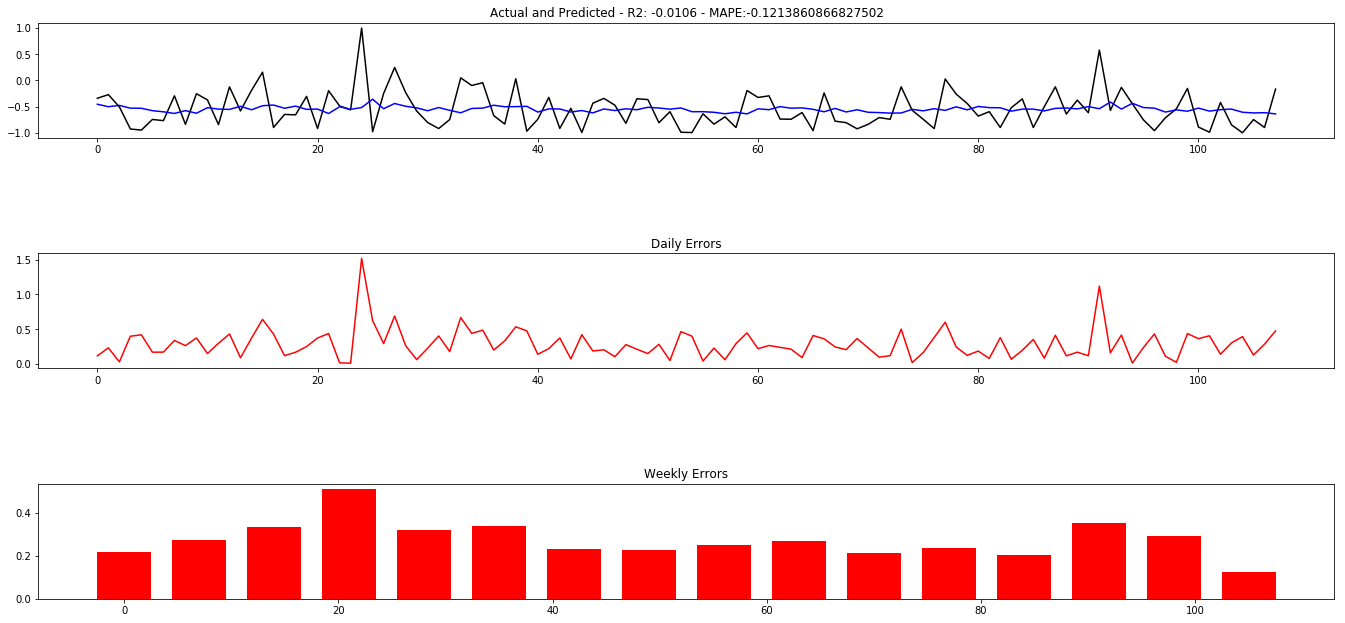

In [22]:
 plot_prediction(Y_val, model.predict(X_val))

# TEST

In [23]:
norm_test_daily_prices = minmax_norm(test_daily_prices, a=-1, b=1)
norm_test_daily_volumes = minmax_norm(test_daily_volumes, a=-1, b=1)

# Not Normalized

In [24]:
#normalized d_list
d_list = [test_daily_volumes, test_daily_prices]

#NOT normalized d_list
#d_list = [weekly_prices, weekly_volumes]

length = len(d_list[0])
step = 1
forecast = 1
windows = [6, 8, 12]

test_data_dict = {}
for window in windows:
    X = []
    Y = []
    for i in range(0, length, step):
        try:
            # Get windowed data
            windowed_features_list = []
            for j in range(len(d_list)):
                windowed_features_list.append(d_list[j][i:i+window])

            # ALWAYS TAKE THE FIRST data 
            y_i = d_list[0][i + window + forecast - 1] # indexing is important.
            x_i = np.column_stack(tuple(windowed_features_list))
        except Exception as e:
            print(e)
            break
        X.append(x_i)
        Y.append(y_i)
    test_data_dict[window] = {'X': np.array(X), 'Y': np.array(Y)}

index 61 is out of bounds for axis 0 with size 61
index 61 is out of bounds for axis 0 with size 61
index 61 is out of bounds for axis 0 with size 61


# Normalized

In [25]:
#normalized d_list
d_list = [norm_test_daily_volumes, norm_test_daily_prices]

#NOT normalized d_list
#d_list = [weekly_prices, weekly_volumes]

length = len(d_list[0])
step = 1
forecast = 1
windows = [6, 8, 12]

norm_test_data_dict = {}
for window in windows:
    X = []
    Y = []
    for i in range(0, length, step):
        try:
            # Get windowed data
            windowed_features_list = []
            for j in range(len(d_list)):
                windowed_features_list.append(d_list[j][i:i+window])

            # ALWAYS TAKE THE FIRST data 
            y_i = d_list[0][i + window + forecast - 1] # indexing is important.
            x_i = np.column_stack(tuple(windowed_features_list))
        except Exception as e:
            print(e)
            break
        X.append(x_i)
        Y.append(y_i)
    norm_test_data_dict[window] = {'X': np.array(X), 'Y': np.array(Y)}

index 61 is out of bounds for axis 0 with size 61
index 61 is out of bounds for axis 0 with size 61
index 61 is out of bounds for axis 0 with size 61


In [26]:
X_test = norm_test_data_dict[w]['X']
#Y_test = test_data_dict[w]['Y']
not_norm_true_values = test_data_dict[w]['Y']

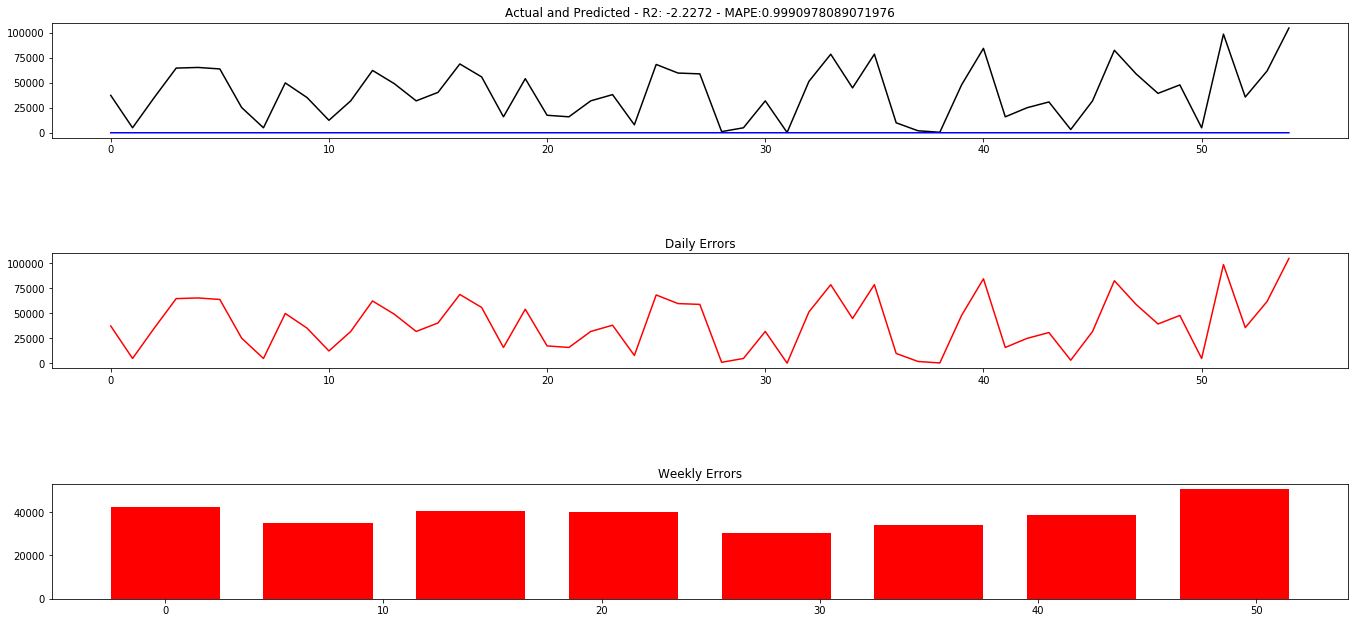

In [27]:
pred_y = model.predict(X_test)
pred_yy = minmax_denorm(test_daily_prices, pred_y, a=-1, b=1)
plot_prediction(not_norm_true_values, pred_yy)

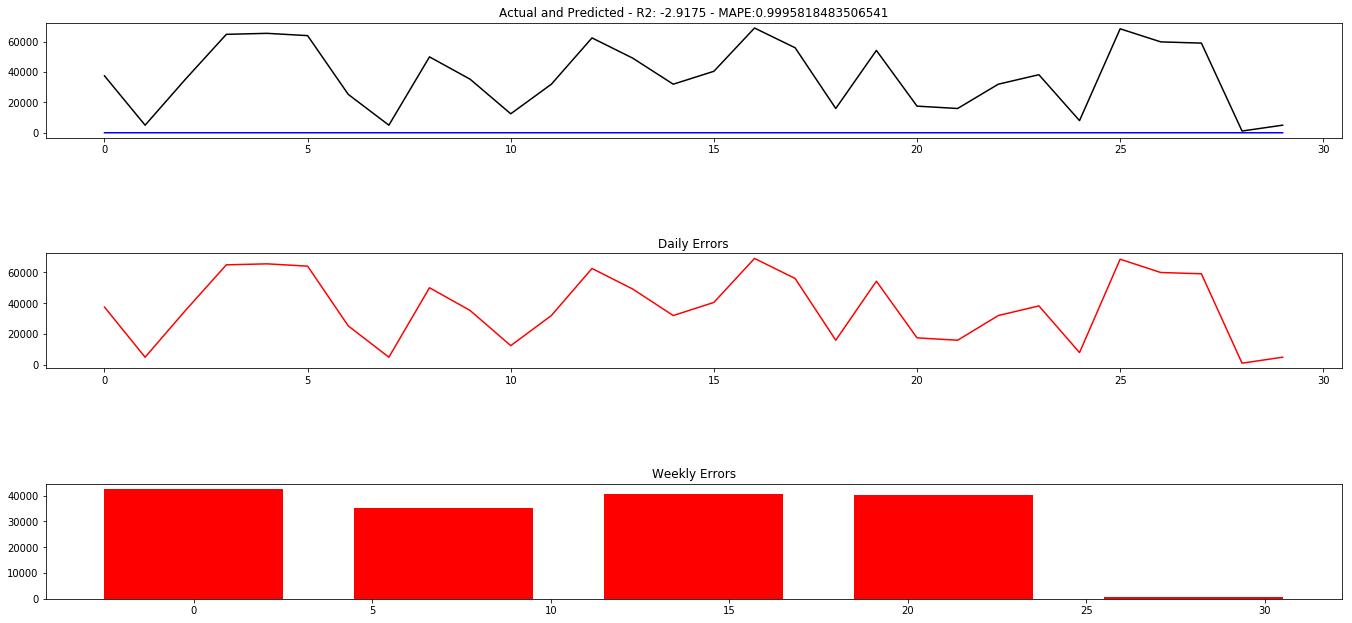

In [28]:
t=0
tp = 30
plot_prediction(not_norm_true_values[t:t+tp], pred_yy[t:t+tp])

# Training with Non-Normalized Data

In [29]:
nX_ = data_dict[w]['X']
nY_ = data_dict[w]['Y']
X_train_, X_val_, Y_train_, Y_val_ = get_train_validation(nX_, nY_)

In [30]:
print('X_train_: '+str(X_train_.shape))
print('X_val_: '+str(X_val_.shape))

X_train_: (432, 6, 2)
X_val_: (108, 6, 2)


In [31]:
print(X_train_[0])
print(Y_train_[0])
print('*'*50)
print(X_train_[1])
print(Y_train_[1])
print('*'*50)

[[1.42727800e+05 3.44864252e+00]
 [3.43000000e+04 4.18564490e+00]
 [1.60000000e+04 4.05010000e+00]
 [9.21372000e+04 3.48854046e+00]
 [9.10000000e+04 3.20351626e+00]
 [6.85000000e+04 3.46203679e+00]]
14000.0
**************************************************
[[3.43000000e+04 4.18564490e+00]
 [1.60000000e+04 4.05010000e+00]
 [9.21372000e+04 3.48854046e+00]
 [9.10000000e+04 3.20351626e+00]
 [6.85000000e+04 3.46203679e+00]
 [1.40000000e+04 4.80211500e+00]]
55500.0
**************************************************


In [32]:
learning_rate=0.0001
epochs=1000
verbose=1
model_dir = 'models/'
model_save_name = model_dir + 'bidirlstm_multivariate_model_paracetamol_quantity_no_norm.h5'
    
#opt_1 = tf.keras.optimizers.Adam(learning_rate)
opt_1 = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
loss_func = tf.keras.losses.mean_squared_error

metrics = []
metrics.append(tf.keras.metrics.mean_absolute_error)
metrics.append(tf.keras.metrics.mean_squared_error)
metrics.append(tf.keras.metrics.mean_absolute_percentage_error)

print("Model will be saved at: " + model_save_name)
model.compile(optimizer=opt_1, 
                  loss=loss_func, 
                  metrics=metrics)
    
callbacks = []
cp = tf.keras.callbacks.ModelCheckpoint(filepath=model_save_name, verbose=1, save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
    
callbacks.append(cp)
callbacks.append(early_stop)

Model will be saved at: models/bidirlstm_multivariate_model_paracetamol_quantity_no_norm.h5


In [33]:
history = model.fit(X_train_, Y_train_, epochs = epochs,  batch_size = batch_size, 
                    verbose=verbose, validation_data=(X_val_, Y_val_), validation_split=0.8, callbacks=callbacks)

Train on 432 samples, validate on 108 samples
Epoch 1/1000
352/432 [=======================>......] - ETA: 0s - loss: 1599126690.9091 - mean_absolute_error: 29585.8981 - mean_squared_error: 1599126690.9091 - mean_absolute_percentage_error: 3494.8582
Epoch 00001: val_loss improved from inf to 1748981489.77778, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_no_norm.h5
432/432 [==============================] - 3s 6ms/step - loss: 1539072200.2963 - mean_absolute_error: 29078.3589 - mean_squared_error: 1539072200.2963 - mean_absolute_percentage_error: 2919.3380 - val_loss: 1748981489.7778 - val_mean_absolute_error: 30033.7874 - val_mean_squared_error: 1748981489.7778 - val_mean_absolute_percentage_error: 1151.4899
Epoch 2/1000
416/432 [===========================>..] - ETA: 0s - loss: 1470767468.3077 - mean_absolute_error: 28616.7946 - mean_squared_error: 1470767468.3077 - mean_absolute_percentage_error: 3001.2195
Epoch 00002: val_loss improved from 1748981489.777

Epoch 13/1000
384/432 [=========================>....] - ETA: 0s - loss: 1509927157.3333 - mean_absolute_error: 28816.3285 - mean_squared_error: 1509927157.3333 - mean_absolute_percentage_error: 3138.9613
Epoch 00013: val_loss improved from 1726877008.59259 to 1725782238.81481, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_no_norm.h5
432/432 [==============================] - 0s 827us/step - loss: 1528040618.6667 - mean_absolute_error: 28809.9572 - mean_squared_error: 1528040618.6667 - mean_absolute_percentage_error: 2827.0246 - val_loss: 1725782238.8148 - val_mean_absolute_error: 29795.0966 - val_mean_squared_error: 1725782238.8148 - val_mean_absolute_percentage_error: 1109.5322
Epoch 14/1000
384/432 [=========================>....] - ETA: 0s - loss: 1414271413.3333 - mean_absolute_error: 28282.4159 - mean_squared_error: 1414271413.3333 - mean_absolute_percentage_error: 3131.1202
Epoch 00014: val_loss improved from 1725782238.81481 to 1724509179.25926, savin

416/432 [===========================>..] - ETA: 0s - loss: 1465932219.0769 - mean_absolute_error: 28195.4239 - mean_squared_error: 1465932219.0769 - mean_absolute_percentage_error: 2912.1638
Epoch 00025: val_loss improved from 1719641016.88889 to 1718901138.96296, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_no_norm.h5
432/432 [==============================] - 0s 834us/step - loss: 1520219761.7778 - mean_absolute_error: 28650.5754 - mean_squared_error: 1520219761.7778 - mean_absolute_percentage_error: 2806.3502 - val_loss: 1718901138.9630 - val_mean_absolute_error: 29737.1320 - val_mean_squared_error: 1718901138.9630 - val_mean_absolute_percentage_error: 1096.6237
Epoch 26/1000
416/432 [===========================>..] - ETA: 0s - loss: 1548927537.2308 - mean_absolute_error: 28849.3579 - mean_squared_error: 1548927537.2308 - mean_absolute_percentage_error: 2892.9474
Epoch 00026: val_loss improved from 1718901138.96296 to 1718687781.92593, saving model to mod

Epoch 37/1000
416/432 [===========================>..] - ETA: 0s - loss: 1533285356.3077 - mean_absolute_error: 28629.5616 - mean_squared_error: 1533285356.3077 - mean_absolute_percentage_error: 2777.1404
Epoch 00037: val_loss improved from 1712351236.74074 to 1712032488.29630, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_no_norm.h5
432/432 [==============================] - 0s 824us/step - loss: 1515319409.7778 - mean_absolute_error: 28570.9149 - mean_squared_error: 1515319409.7778 - mean_absolute_percentage_error: 2788.8733 - val_loss: 1712032488.2963 - val_mean_absolute_error: 29678.4355 - val_mean_squared_error: 1712032488.2963 - val_mean_absolute_percentage_error: 1085.7941
Epoch 38/1000
416/432 [===========================>..] - ETA: 0s - loss: 1507637400.6154 - mean_absolute_error: 28364.8142 - mean_squared_error: 1507637400.6154 - mean_absolute_percentage_error: 2887.7110
Epoch 00038: val_loss improved from 1712032488.29630 to 1711424265.48148, savin

432/432 [==============================] - 0s 960us/step - loss: 1511838935.7037 - mean_absolute_error: 28521.6895 - mean_squared_error: 1511838935.7037 - mean_absolute_percentage_error: 2791.5366 - val_loss: 1708160004.7407 - val_mean_absolute_error: 29644.7378 - val_mean_squared_error: 1708160004.7407 - val_mean_absolute_percentage_error: 1083.0271
Epoch 49/1000
416/432 [===========================>..] - ETA: 0s - loss: 1504123795.6923 - mean_absolute_error: 28544.7752 - mean_squared_error: 1504123795.6923 - mean_absolute_percentage_error: 2888.4496
Epoch 00049: val_loss improved from 1708160004.74074 to 1707619422.81481, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_no_norm.h5
432/432 [==============================] - 0s 1000us/step - loss: 1511414418.9630 - mean_absolute_error: 28515.3977 - mean_squared_error: 1511414418.9630 - mean_absolute_percentage_error: 2790.5116 - val_loss: 1707619422.8148 - val_mean_absolute_error: 29638.9572 - val_mean_squared_e

Epoch 61/1000
416/432 [===========================>..] - ETA: 0s - loss: 1477386712.6154 - mean_absolute_error: 28290.3466 - mean_squared_error: 1477386712.6154 - mean_absolute_percentage_error: 2894.1455
Epoch 00061: val_loss did not improve from 1705188129.18519
432/432 [==============================] - 0s 863us/step - loss: 1507815528.2963 - mean_absolute_error: 28500.6014 - mean_squared_error: 1507815528.2963 - mean_absolute_percentage_error: 2791.5189 - val_loss: 1706103229.6296 - val_mean_absolute_error: 29613.9467 - val_mean_squared_error: 1706103229.6296 - val_mean_absolute_percentage_error: 1078.7459
Epoch 62/1000
384/432 [=========================>....] - ETA: 0s - loss: 1536722730.6667 - mean_absolute_error: 28593.3215 - mean_squared_error: 1536722730.6667 - mean_absolute_percentage_error: 3118.7274
Epoch 00062: val_loss did not improve from 1705188129.18519
432/432 [==============================] - 0s 838us/step - loss: 1507505493.3333 - mean_absolute_error: 28498.1945 - 

Epoch 74/1000
416/432 [===========================>..] - ETA: 0s - loss: 1524251864.6154 - mean_absolute_error: 28502.2957 - mean_squared_error: 1524251864.6154 - mean_absolute_percentage_error: 2941.5318
Epoch 00074: val_loss did not improve from 1704611176.29630
432/432 [==============================] - 0s 775us/step - loss: 1506037584.5926 - mean_absolute_error: 28471.9287 - mean_squared_error: 1506037584.5926 - mean_absolute_percentage_error: 2838.7643 - val_loss: 1704688559.4074 - val_mean_absolute_error: 29623.3865 - val_mean_squared_error: 1704688559.4074 - val_mean_absolute_percentage_error: 1094.9802
Epoch 75/1000
416/432 [===========================>..] - ETA: 0s - loss: 1472176147.6923 - mean_absolute_error: 28173.0038 - mean_squared_error: 1472176147.6923 - mean_absolute_percentage_error: 2927.2253
Epoch 00075: val_loss improved from 1704611176.29630 to 1704600215.70370, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_no_norm.h5
432/432 [==========

Epoch 86/1000
416/432 [===========================>..] - ETA: 0s - loss: 1484886931.6923 - mean_absolute_error: 28262.1752 - mean_squared_error: 1484886931.6923 - mean_absolute_percentage_error: 2825.0441
Epoch 00086: val_loss did not improve from 1702229432.88889
432/432 [==============================] - 0s 766us/step - loss: 1503825716.1481 - mean_absolute_error: 28435.6808 - mean_squared_error: 1503825716.1481 - mean_absolute_percentage_error: 2841.3370 - val_loss: 1702396705.1852 - val_mean_absolute_error: 29599.0185 - val_mean_squared_error: 1702396705.1852 - val_mean_absolute_percentage_error: 1093.9250
Epoch 87/1000
416/432 [===========================>..] - ETA: 0s - loss: 1533889762.4615 - mean_absolute_error: 28763.2742 - mean_squared_error: 1533889762.4615 - mean_absolute_percentage_error: 2924.8185
Epoch 00087: val_loss did not improve from 1702229432.88889
432/432 [==============================] - 0s 801us/step - loss: 1503702205.6296 - mean_absolute_error: 28438.4222 - 

Epoch 98/1000
416/432 [===========================>..] - ETA: 0s - loss: 1488698564.9231 - mean_absolute_error: 28239.9216 - mean_squared_error: 1488698564.9231 - mean_absolute_percentage_error: 2953.5770
Epoch 00098: val_loss improved from 1700350976.00000 to 1700035683.55556, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_no_norm.h5
432/432 [==============================] - 0s 909us/step - loss: 1501493826.3704 - mean_absolute_error: 28403.0702 - mean_squared_error: 1501493826.3704 - mean_absolute_percentage_error: 2846.7089 - val_loss: 1700035683.5556 - val_mean_absolute_error: 29572.9132 - val_mean_squared_error: 1700035683.5556 - val_mean_absolute_percentage_error: 1092.4460
Epoch 99/1000
416/432 [===========================>..] - ETA: 0s - loss: 1476003894.1538 - mean_absolute_error: 28164.7318 - mean_squared_error: 1476003894.1538 - mean_absolute_percentage_error: 2953.9710
Epoch 00099: val_loss improved from 1700035683.55556 to 1699974546.96296, savin

Epoch 110/1000
384/432 [=========================>....] - ETA: 0s - loss: 1525514784.0000 - mean_absolute_error: 28545.4123 - mean_squared_error: 1525514784.0000 - mean_absolute_percentage_error: 3033.5810
Epoch 00110: val_loss improved from 1698504983.70370 to 1698323674.07407, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_no_norm.h5
432/432 [==============================] - 1s 2ms/step - loss: 1499299612.4444 - mean_absolute_error: 28375.8136 - mean_squared_error: 1499299612.4444 - mean_absolute_percentage_error: 2857.8652 - val_loss: 1698323674.0741 - val_mean_absolute_error: 29556.2188 - val_mean_squared_error: 1698323674.0741 - val_mean_absolute_percentage_error: 1094.7246
Epoch 111/1000
384/432 [=========================>....] - ETA: 0s - loss: 1542070026.6667 - mean_absolute_error: 28760.5117 - mean_squared_error: 1542070026.6667 - mean_absolute_percentage_error: 3189.6044
Epoch 00111: val_loss improved from 1698323674.07407 to 1698084570.07407, savin

Epoch 00121: val_loss improved from 1696738147.55556 to 1696552651.85185, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_no_norm.h5
432/432 [==============================] - 1s 1ms/step - loss: 1497371050.6667 - mean_absolute_error: 28349.1518 - mean_squared_error: 1497371050.6667 - mean_absolute_percentage_error: 2862.0886 - val_loss: 1696552651.8519 - val_mean_absolute_error: 29537.0342 - val_mean_squared_error: 1696552651.8519 - val_mean_absolute_percentage_error: 1094.6125
Epoch 122/1000
416/432 [===========================>..] - ETA: 0s - loss: 1503526675.6923 - mean_absolute_error: 28371.2036 - mean_squared_error: 1503526675.6923 - mean_absolute_percentage_error: 2970.4187
Epoch 00122: val_loss did not improve from 1696552651.85185
432/432 [==============================] - 0s 813us/step - loss: 1497356216.8889 - mean_absolute_error: 28349.8940 - mean_squared_error: 1497356216.8889 - mean_absolute_percentage_error: 2865.7006 - val_loss: 1696552770.3704 

Epoch 133/1000
416/432 [===========================>..] - ETA: 0s - loss: 1524568625.2308 - mean_absolute_error: 28526.2640 - mean_squared_error: 1524568625.2308 - mean_absolute_percentage_error: 2966.6328
Epoch 00133: val_loss improved from 1694993502.81481 to 1694854684.44444, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_no_norm.h5
432/432 [==============================] - 0s 862us/step - loss: 1495224798.8148 - mean_absolute_error: 28324.0482 - mean_squared_error: 1495224798.8148 - mean_absolute_percentage_error: 2872.3305 - val_loss: 1694854684.4444 - val_mean_absolute_error: 29520.3298 - val_mean_squared_error: 1694854684.4444 - val_mean_absolute_percentage_error: 1096.9571
Epoch 134/1000
416/432 [===========================>..] - ETA: 0s - loss: 1464957932.3077 - mean_absolute_error: 27941.1584 - mean_squared_error: 1464957932.3077 - mean_absolute_percentage_error: 2971.0077
Epoch 00134: val_loss improved from 1694854684.44444 to 1694725921.18519, sav

432/432 [==============================] - 0s 867us/step - loss: 1493342155.8519 - mean_absolute_error: 28304.4248 - mean_squared_error: 1493342155.8519 - mean_absolute_percentage_error: 2884.2289 - val_loss: 1693512841.4815 - val_mean_absolute_error: 29508.0550 - val_mean_squared_error: 1693512841.4815 - val_mean_absolute_percentage_error: 1099.8702
Epoch 145/1000
416/432 [===========================>..] - ETA: 0s - loss: 1470360019.6923 - mean_absolute_error: 28036.5909 - mean_squared_error: 1470360019.6923 - mean_absolute_percentage_error: 2994.6320
Epoch 00145: val_loss improved from 1693512841.48148 to 1693481140.14815, saving model to models/bidirlstm_multivariate_model_paracetamol_quantity_no_norm.h5
432/432 [==============================] - 0s 864us/step - loss: 1493118383.4074 - mean_absolute_error: 28302.5262 - mean_squared_error: 1493118383.4074 - mean_absolute_percentage_error: 2886.5207 - val_loss: 1693481140.1481 - val_mean_absolute_error: 29508.4133 - val_mean_squared_e

416/432 [===========================>..] - ETA: 0s - loss: 1496919310.7692 - mean_absolute_error: 28363.0808 - mean_squared_error: 1496919310.7692 - mean_absolute_percentage_error: 3006.4643
Epoch 00156: val_loss did not improve from 1692041713.77778
432/432 [==============================] - 0s 808us/step - loss: 1491285442.3704 - mean_absolute_error: 28284.3659 - mean_squared_error: 1491285442.3704 - mean_absolute_percentage_error: 2897.7423 - val_loss: 1692210455.7037 - val_mean_absolute_error: 29497.6761 - val_mean_squared_error: 1692210455.7037 - val_mean_absolute_percentage_error: 1104.7056
Epoch 157/1000
416/432 [===========================>..] - ETA: 0s - loss: 1445849329.2308 - mean_absolute_error: 27977.0566 - mean_squared_error: 1445849329.2308 - mean_absolute_percentage_error: 3008.9891
Epoch 00157: val_loss did not improve from 1692041713.77778
432/432 [==============================] - 0s 785us/step - loss: 1490963043.5556 - mean_absolute_error: 28282.0710 - mean_squared_

Epoch 169/1000
384/432 [=========================>....] - ETA: 0s - loss: 1517389594.6667 - mean_absolute_error: 28293.1138 - mean_squared_error: 1517389594.6667 - mean_absolute_percentage_error: 3281.8350
Epoch 00169: val_loss did not improve from 1691855725.03704
432/432 [==============================] - 0s 785us/step - loss: 1467792549.9259 - mean_absolute_error: 28146.6140 - mean_squared_error: 1467792549.9259 - mean_absolute_percentage_error: 2968.5241 - val_loss: 1718511108.7407 - val_mean_absolute_error: 30224.4436 - val_mean_squared_error: 1718511108.7407 - val_mean_absolute_percentage_error: 1121.7775
Epoch 170/1000
416/432 [===========================>..] - ETA: 0s - loss: 1491100706.4615 - mean_absolute_error: 28413.3341 - mean_squared_error: 1491100706.4615 - mean_absolute_percentage_error: 3074.1948
Epoch 00170: val_loss did not improve from 1691855725.03704
432/432 [==============================] - 0s 796us/step - loss: 1467682882.3704 - mean_absolute_error: 28142.1463 

416/432 [===========================>..] - ETA: 0s - loss: 1475777383.3846 - mean_absolute_error: 28128.5697 - mean_squared_error: 1475777383.3846 - mean_absolute_percentage_error: 3067.9638
Epoch 00182: val_loss did not improve from 1691855725.03704
432/432 [==============================] - 1s 2ms/step - loss: 1465740292.7407 - mean_absolute_error: 28107.8073 - mean_squared_error: 1465740292.7407 - mean_absolute_percentage_error: 2959.1608 - val_loss: 1715068809.4815 - val_mean_absolute_error: 30181.0278 - val_mean_squared_error: 1715068809.4815 - val_mean_absolute_percentage_error: 1116.8911
Epoch 183/1000
416/432 [===========================>..] - ETA: 0s - loss: 1502216103.3846 - mean_absolute_error: 28526.9507 - mean_squared_error: 1502216103.3846 - mean_absolute_percentage_error: 3069.7954
Epoch 00183: val_loss did not improve from 1691855725.03704
432/432 [==============================] - 1s 2ms/step - loss: 1465563739.2593 - mean_absolute_error: 28105.9818 - mean_squared_erro

384/432 [=========================>....] - ETA: 0s - loss: 1562652458.6667 - mean_absolute_error: 28886.5436 - mean_squared_error: 1562652458.6667 - mean_absolute_percentage_error: 3234.0021
Epoch 00195: val_loss did not improve from 1691855725.03704
432/432 [==============================] - 0s 915us/step - loss: 1463695406.2222 - mean_absolute_error: 28081.2622 - mean_squared_error: 1463695406.2222 - mean_absolute_percentage_error: 2964.2601 - val_loss: 1712893653.3333 - val_mean_absolute_error: 30155.9125 - val_mean_squared_error: 1712893653.3333 - val_mean_absolute_percentage_error: 1117.5185
Epoch 196/1000
352/432 [=======================>......] - ETA: 0s - loss: 1479538100.3636 - mean_absolute_error: 28485.6264 - mean_squared_error: 1479538100.3636 - mean_absolute_percentage_error: 3569.8793
Epoch 00196: val_loss did not improve from 1691855725.03704
432/432 [==============================] - 0s 982us/step - loss: 1463570872.8889 - mean_absolute_error: 28079.2630 - mean_squared_

416/432 [===========================>..] - ETA: 0s - loss: 1459682628.9231 - mean_absolute_error: 27999.5469 - mean_squared_error: 1459682628.9231 - mean_absolute_percentage_error: 3076.3568
Epoch 00208: val_loss did not improve from 1691855725.03704
432/432 [==============================] - 0s 776us/step - loss: 1461625211.2593 - mean_absolute_error: 28052.5265 - mean_squared_error: 1461625211.2593 - mean_absolute_percentage_error: 2968.6245 - val_loss: 1710446065.7778 - val_mean_absolute_error: 30125.9419 - val_mean_squared_error: 1710446065.7778 - val_mean_absolute_percentage_error: 1116.3145
Epoch 209/1000
416/432 [===========================>..] - ETA: 0s - loss: 1473642294.1538 - mean_absolute_error: 28205.4035 - mean_squared_error: 1473642294.1538 - mean_absolute_percentage_error: 3074.8046
Epoch 00209: val_loss did not improve from 1691855725.03704
432/432 [==============================] - 0s 806us/step - loss: 1461469814.5185 - mean_absolute_error: 28049.4714 - mean_squared_

416/432 [===========================>..] - ETA: 0s - loss: 1451943625.8462 - mean_absolute_error: 27960.8511 - mean_squared_error: 1451943625.8462 - mean_absolute_percentage_error: 3077.4642
Epoch 00221: val_loss did not improve from 1691855725.03704
432/432 [==============================] - 0s 810us/step - loss: 1459523413.3333 - mean_absolute_error: 28029.6724 - mean_squared_error: 1459523413.3333 - mean_absolute_percentage_error: 2980.0499 - val_loss: 1709352661.3333 - val_mean_absolute_error: 30106.1369 - val_mean_squared_error: 1709352661.3333 - val_mean_absolute_percentage_error: 1119.5254
Epoch 222/1000
416/432 [===========================>..] - ETA: 0s - loss: 1435071734.1538 - mean_absolute_error: 28001.6821 - mean_squared_error: 1435071734.1538 - mean_absolute_percentage_error: 3071.7430
Epoch 00222: val_loss did not improve from 1691855725.03704
432/432 [==============================] - 0s 810us/step - loss: 1459336580.7407 - mean_absolute_error: 28028.1870 - mean_squared_

416/432 [===========================>..] - ETA: 0s - loss: 1442926242.4615 - mean_absolute_error: 27805.7674 - mean_squared_error: 1442926242.4615 - mean_absolute_percentage_error: 3089.5233
Epoch 00234: val_loss did not improve from 1691855725.03704
432/432 [==============================] - 0s 767us/step - loss: 1457284224.0000 - mean_absolute_error: 28006.7185 - mean_squared_error: 1457284224.0000 - mean_absolute_percentage_error: 2991.2065 - val_loss: 1707800173.0370 - val_mean_absolute_error: 30085.0595 - val_mean_squared_error: 1707800173.0370 - val_mean_absolute_percentage_error: 1122.3817
Epoch 235/1000
416/432 [===========================>..] - ETA: 0s - loss: 1474457452.3077 - mean_absolute_error: 28169.7354 - mean_squared_error: 1474457452.3077 - mean_absolute_percentage_error: 3102.8905
Epoch 00235: val_loss did not improve from 1691855725.03704
432/432 [==============================] - 0s 788us/step - loss: 1457071677.6296 - mean_absolute_error: 28003.9905 - mean_squared_

416/432 [===========================>..] - ETA: 0s - loss: 1466823084.3077 - mean_absolute_error: 28139.9232 - mean_squared_error: 1466823084.3077 - mean_absolute_percentage_error: 3102.2116
Epoch 00247: val_loss did not improve from 1691855725.03704
432/432 [==============================] - 0s 809us/step - loss: 1454872040.2963 - mean_absolute_error: 27977.6399 - mean_squared_error: 1454872040.2963 - mean_absolute_percentage_error: 3000.9659 - val_loss: 1705733494.5185 - val_mean_absolute_error: 30064.4308 - val_mean_squared_error: 1705733494.5185 - val_mean_absolute_percentage_error: 1124.2412
Epoch 248/1000
416/432 [===========================>..] - ETA: 0s - loss: 1483508401.2308 - mean_absolute_error: 28243.2898 - mean_squared_error: 1483508401.2308 - mean_absolute_percentage_error: 3080.2806
Epoch 00248: val_loss did not improve from 1691855725.03704
432/432 [==============================] - 0s 794us/step - loss: 1454777578.6667 - mean_absolute_error: 27977.4839 - mean_squared_

416/432 [===========================>..] - ETA: 0s - loss: 1443201536.0000 - mean_absolute_error: 27867.3090 - mean_squared_error: 1443201536.0000 - mean_absolute_percentage_error: 3080.1616
Epoch 00260: val_loss did not improve from 1691855725.03704
432/432 [==============================] - 0s 785us/step - loss: 1452461146.0741 - mean_absolute_error: 27952.0148 - mean_squared_error: 1452461146.0741 - mean_absolute_percentage_error: 3011.2952 - val_loss: 1703818443.8519 - val_mean_absolute_error: 30049.0828 - val_mean_squared_error: 1703818443.8519 - val_mean_absolute_percentage_error: 1126.5122


In [34]:
model.evaluate(X_val_, Y_val_)

108/108 [==============================] - 0s 3ms/step


[1703818443.851852, 30049.08282696759, 1703818443.851852, 1126.5121753833912]

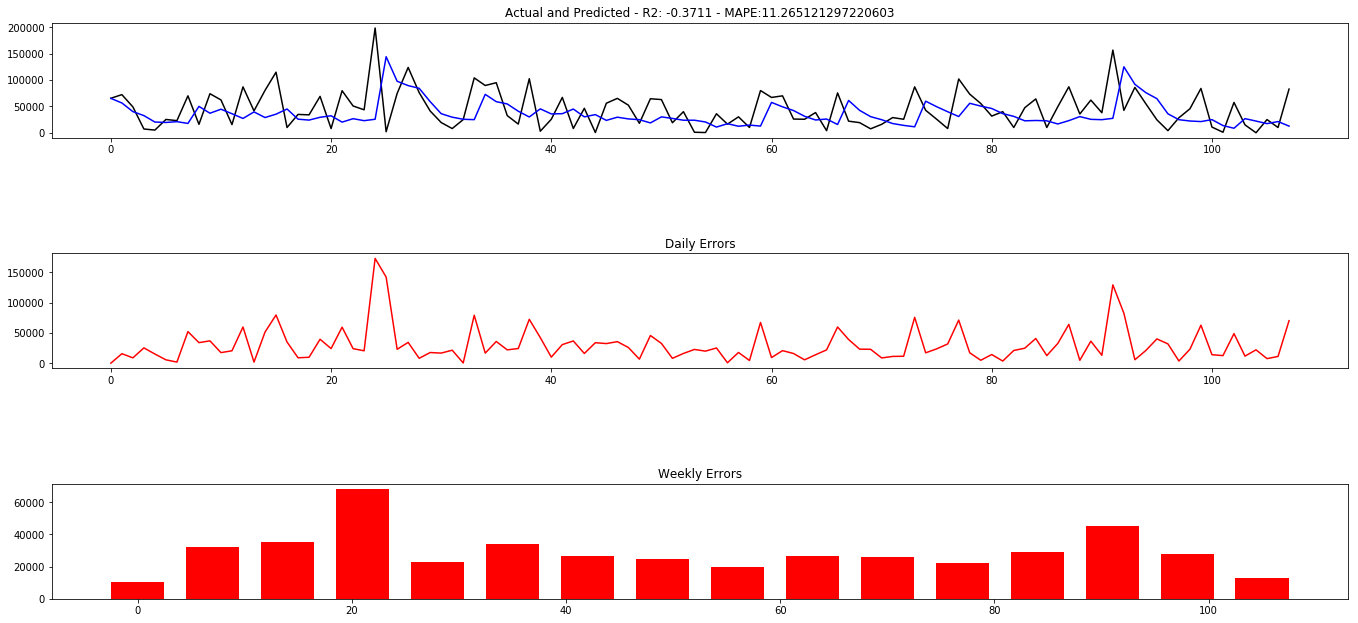

In [35]:
plot_prediction(Y_val_, model.predict(X_val_))

# Test Non-Normalized Model

In [36]:
X_test_ = test_data_dict[w]['X']
Y_test_ = test_data_dict[w]['Y']

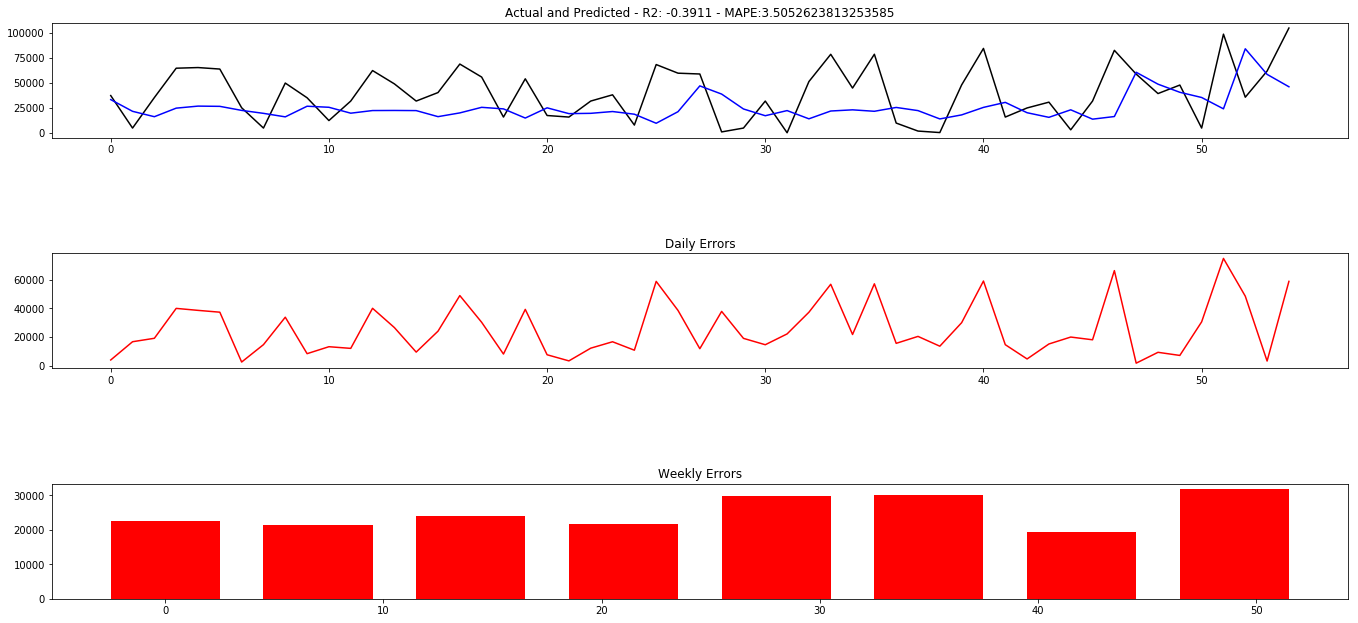

In [37]:
pred_y_ = model.predict(X_test_)
plot_prediction(Y_test_, pred_y_)

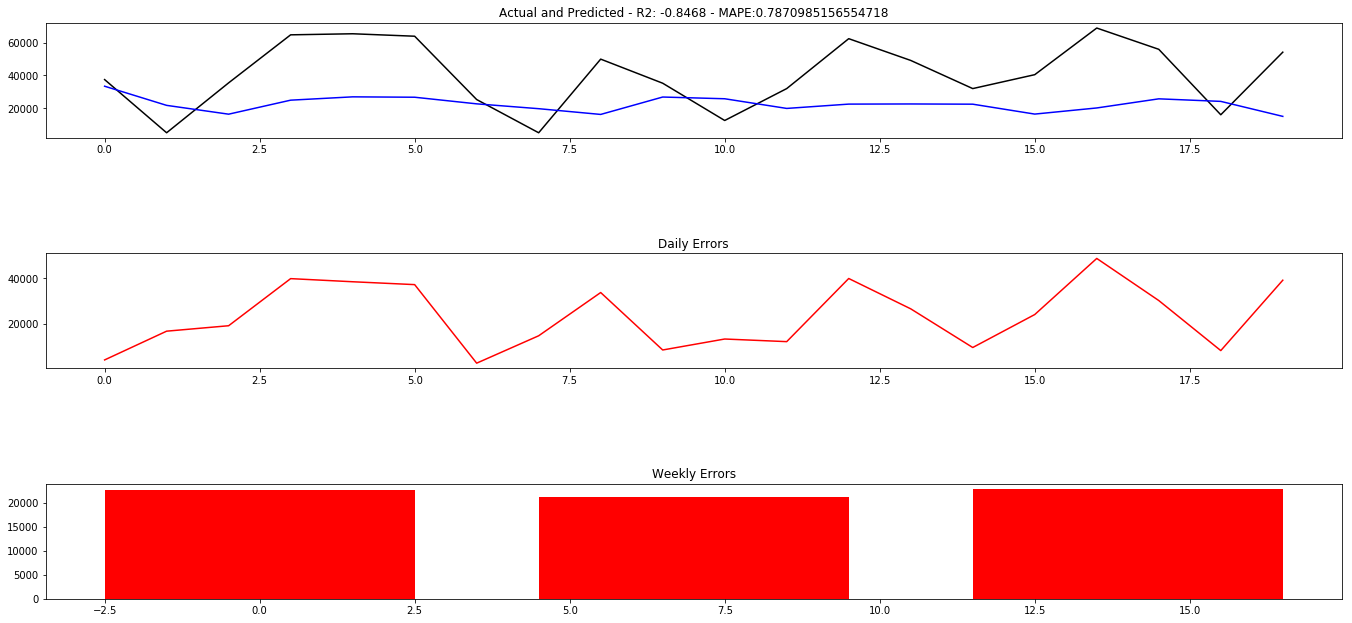

In [38]:
t=0
tp = 20
plot_prediction(Y_test_[t:t+tp], pred_y_[t:t+tp])